In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import gymnasium as gym
import numpy as np

In [3]:
# nonlinear, dynamic, cartesian
# from irbfn_mpc.nonlinear_dmpc import NMPCPlanner

# nonlinear, kinematic, frenet
import irbfn_mpc.nonlinear_dmpc_frenet as ndf

2024-09-06 19:17:39.101771: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [4]:
from IPython.display import HTML, display
%matplotlib inline

In [5]:
env = gym.make(
    "f1tenth_gym:f1tenth-v0",
    config={
        "map": "Spielberg_blank",
        "observation_config": {
            "type": "features",
            "features": [
                "pose_x",
                "pose_y",
                "delta",
                "linear_vel_x",
                "linear_vel_y",
                "pose_theta",
                "ang_vel_z",
                "beta",
            ],
        },
        "num_agents": 1,
        "control_input": "accl",
    },
    render_mode="rgb_array",
)
env = gym.wrappers.RecordVideo(env, "video_nmpc")

/usr/local/lib/python3.12/dist-packages/f1tenth_gym/envs/action.py:155: UserWarning: Only one control mode specified, using accl for longitudinal control and defaulting to steering speed for steering
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /home/irbfn/scripts/video_nmpc folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [6]:
track = env.unwrapped.track

In [7]:
import importlib
importlib.reload(ndf)

<module 'irbfn_mpc.nonlinear_dmpc_frenet' from '/home/irbfn/src/irbfn_mpc/nonlinear_dmpc_frenet.py'>

In [8]:
mpc = ndf.NMPCPlanner(track=track)

In [9]:
env.unwrapped.add_render_callback(mpc.render_waypoints)
env.unwrapped.add_render_callback(mpc.render_mpc_sol)
env.unwrapped.add_render_callback(mpc.render_local_plan)

In [10]:
poses = np.array(
    [
        [
            env.unwrapped.track.raceline.xs[0] - 0.01,
            env.unwrapped.track.raceline.ys[0] - 0.01,
            env.unwrapped.track.raceline.yaws[0],
        ]
    ]
)
obs, info = env.reset(options={"poses": poses})
done = False

step = 0

while not done and step <= 10000:
    current_state = obs["agent_0"]
    
    if step < 10:
        accl = 3.0
        steer_vel = 0.0
    else:
        accl, steer_vel = mpc.plan(current_state)
        # print(f"accl {accl}, steer_vel {steer_vel}")

    action = env.action_space.sample()
    action[0] = [steer_vel, accl]
    # print(f"current state {current_state}")
    # print(f"goal state {goal_state}")
    # print(f"taking action {action[0]}")

    obs, step_reward, done, truncated, info = env.step(action)
    step += 1

env.close()

/usr/local/lib/python3.12/dist-packages/gymnasium/spaces/box.py:240: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Moviepy - Building video /home/irbfn/scripts/video_nmpc/rl-video-episode-0.mp4.
Moviepy - Writing video /home/irbfn/scripts/video_nmpc/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/irbfn/scripts/video_nmpc/rl-video-episode-0.mp4


In [11]:
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%.9g" % x))

In [12]:
print(mpc.opti.debug.value(mpc.X))

[[337.801586 338.601044 339.40058 340.20028 341.0001 341.799958]
 [0.00830843756 0.0151345041 0.0192839184 0.0210097774 0.0210351707 0.0202516083]
 [-0.00219145766 -0.00205698162 -0.000570310583 0.000201321935 0.000313899806 0.000313899806]
 [7.99496317 7.99464383 7.99612168 7.99776661 7.99857021 7.99857674]
 [0.0294971168 0.0365200309 0.038701238 0.0278086872 0.0129768057 0.00252345947]
 [-0.0372428671 -0.041186537 -0.0245985136 -0.00297035563 0.00697627426 0.00841788841]
 [0.00642373485 0.00234946708 -0.00125139429 -0.00259913195 -0.00228648303 -0.00149090556]]


In [13]:
print(mpc.opti.debug.value(mpc.U))

[[-0.00158784208 0.016301246 0.0169341717 0.00796058827 -4.70517121e-09]
 [0.00134476047 0.0148667103 0.00771632518 0.0011257787 -1.0730303e-13]]


In [14]:
print(mpc.opti.debug.value(mpc.P))

[[337.801586 0 0 0 0 0]
 [0.00830843756 0 0 0 0 0]
 [-0.00219145766 0 0 0 0 0]
 [7.99496317 8 8 8 8 8]
 [0.0294971168 0 0 0 0 0]
 [-0.0372428671 0 0 0 0 0]
 [0.00642373485 0 0 0 0 0]
 [0 4.16000003e-05 4.16000003e-05 4.16000003e-05 4.16000003e-05 4.16000003e-05]]


In [15]:
import casadi as ca

In [16]:
gs = ca.vertcat(0.0, 0.0, 0.0, mpc.ref_path[3][-1], 0.0, 0.0, 0.0, mpc.ref_path[5][0])
accl, steerv = mpc.mpc_prob_solve(goal_state=gs, current_state=obs["agent_0"])

In [17]:
obs["agent_0"]

{'pose_x': 0.19378377,
 'pose_y': -0.7948495,
 'delta': -0.0021820483,
 'linear_vel_x': 7.9949455,
 'linear_vel_y': 0.02994697,
 'pose_theta': 3.409448,
 'ang_vel_z': -0.037072405,
 'beta': 0.0037457203}

In [18]:
env.close()

In [19]:
import glob
import io
import base64

for video_file in glob.glob("video_nmpc/*.mp4"):
    video = io.open(video_file, "rb").read()
    encoded = base64.b64encode(video).decode("ascii")
    display(
        HTML(
            f"""<video width="800" height="auto" controls>
                <source src="data:video/mp4;base64,{encoded}" type="video/mp4" />
            </video>"""
        )
    )

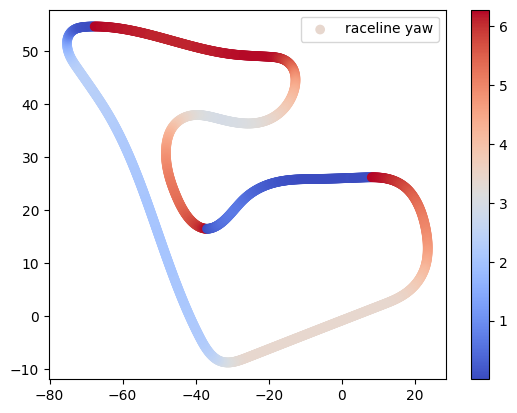

In [20]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(track.raceline.xs, track.raceline.ys, c=track.raceline.yaws, cmap="coolwarm", label="raceline yaw")
plt.legend()
plt.colorbar()
plt.show()